我们来做一个完整的、使用 Sobol' 指数 进行全局敏感性分析的Python示例。这是一个比OAT（一次变一个）复杂得多，但能提供深刻洞察力的高级技术。
我们将分析一个在工程和物理领域非常经典的模型：Ishigami 函数。这个函数之所以著名，是因为它具有强烈的非线性和参数间的交互作用，是检验全局敏感性分析方法的“试金石”。

一、 问题：分析 Ishigami 函数的敏感性

Ishigami 函数 的数学形式如下：
Y = sin(X₁) + a * sin²(X₂) + b * X₃⁴ * sin(X₁)
其中，输入参数 X₁, X₂, X₃ 都是在 [-π, +π] 范围内均匀分布的随机变量。a 和 b 是常数，通常取 a=7, b=0.1。
我们的目标：
使用Sobol'指数来回答以下问题：
哪个参数（X₁, X₂, X₃）对输出 Y 的**方差（不确定性）**贡献最大？
这些参数之间是否存在强烈的交互作用？

二、 Sobol' 指数的思想回顾

一阶指数 (S1)：衡量每个参数单独对输出方差的贡献。例如，S1_X1 就是如果我们只改变X₁，而固定其他参数，能解释输出总方差的百分之多少。所有S1指数之和通常小于1。
二阶指数 (S2)：衡量一对参数的交互作用对输出方差的贡献。例如，S2_X1_X3 衡量的是 X₁ 和 X₃ 共同作用时，产生的**“1+1>2”**的额外效应。
总效应指数 (ST)：衡量每个参数的主效应（S1）加上它与所有其他参数的所有交互效应的总和。ST_X1 就是 X₁ 只要一变动（无论其他参数变不变），能解释输出总方差的百分之多少。
解读的黄金法则：
如果 S1 很高，说明这个参数是主要的“独立贡献者”。
如果 ST 很高，但 S1 很低，说明这个参数本身不重要，但它是关键的**“催化剂”或“团队合作者”**，它与其他参数的交互作用非常强。


C:\Users\AUSA\AppData\Local\Temp\ipykernel_10712\4014596207.py:21: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, N)
e:\Anaconda3\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Saltelli采样生成的总样本数: 8192
          ST   ST_conf
X1  0.555860  0.075203
X2  0.441898  0.041782
X3  0.244675  0.023457
          S1   S1_conf
X1  0.316832  0.058312
X2  0.443763  0.052988
X3  0.012203  0.050477
                S2   S2_conf
(X1, X2)  0.009254  0.077349
(X1, X3)  0.238172  0.104907
(X2, X3) -0.004888  0.074231


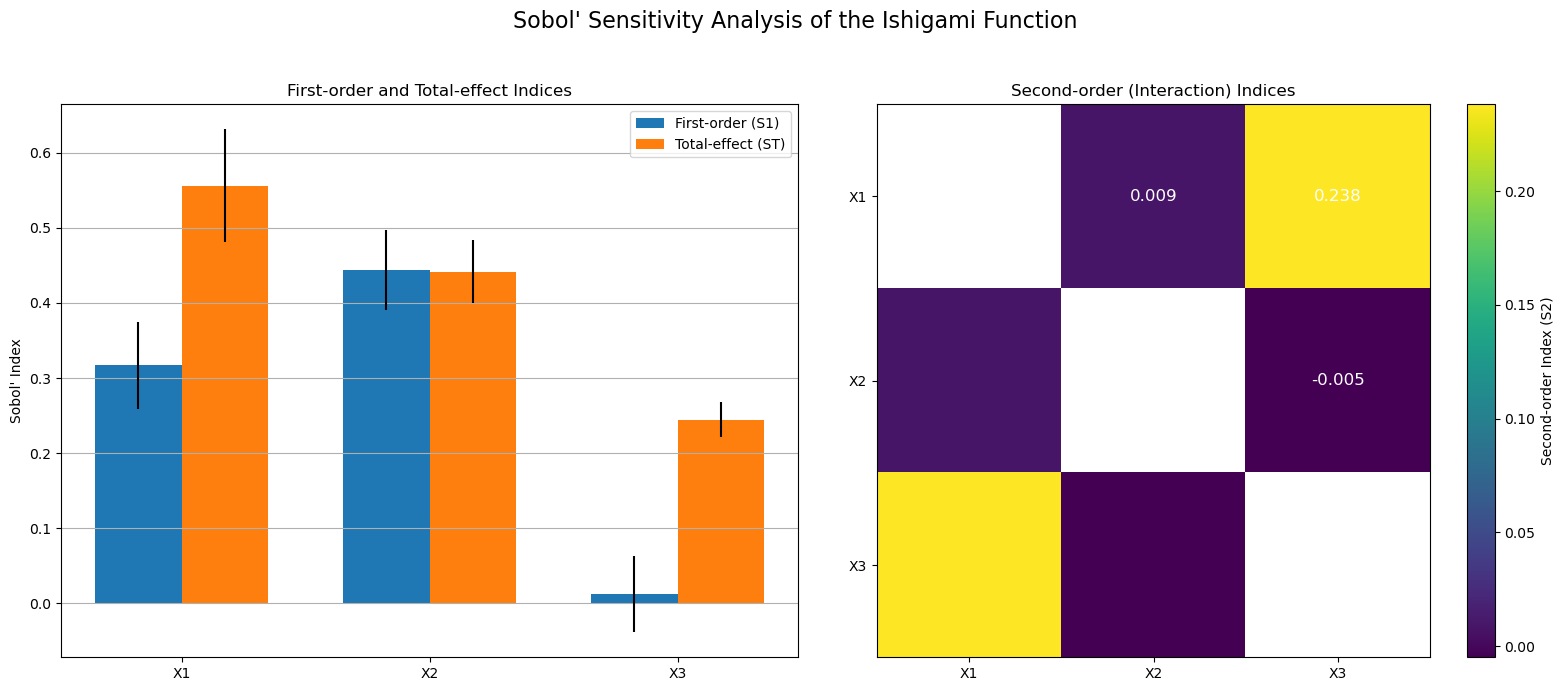


--- Sobol' Indices Summary (First-order and Total-effect) ---
          S1        ST
X1  0.316832  0.555860
X2  0.443763  0.441898
X3  0.012203  0.244675

--- Second-order Indices (S2) ---
          X1        X2        X3
X1       NaN  0.009254  0.238172
X2  0.009254       NaN -0.004888
X3  0.238172 -0.004888       NaN


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

# --- 1. 定义问题 ---
# SALib内置了Ishigami函数，我们直接使用
# 定义模型的输入参数
problem = {
    'num_vars': 3,
    'names': ['X1', 'X2', 'X3'],
    'bounds': [[-np.pi, np.pi]] * 3
}

# --- 2. 生成输入样本 ---
# 使用Saltelli采样器为Sobol'分析生成样本
# Saltelli采样是一种特殊的采样方式，专门用于高效计算Sobol'指数
# N是基础样本量，总样本数会是 N * (2 * D + 2)，D是参数数量
N = 1024  # 基础样本量，通常取2的幂次
param_values = saltelli.sample(problem, N)

print(f"Saltelli采样生成的总样本数: {param_values.shape[0]}")

# --- 3. 运行模型 ---
# Ishigami.evaluate() 是我们模型的“黑箱”
# 在真实问题中，这里会是你自己的复杂模型函数
Y = Ishigami.evaluate(param_values)

# --- 4. 执行Sobol'分析 ---
# `calc_second_order=True` 表示我们想计算二阶指数
Si = sobol.analyze(problem, Y, calc_second_order=True, print_to_console=True)

# `Si` 是一个字典，包含了所有计算出的指数和置信区间

# --- 5. 可视化结果 ---
# 将结果转换为更容易处理的格式
total_effects = Si['ST']
first_order = Si['S1']
second_order = Si['S2']

# 绘制一阶和总效应指数的条形图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Sobol\' Sensitivity Analysis of the Ishigami Function', fontsize=16)

# 图1: 一阶和总效应指数
indices = np.arange(problem['num_vars'])
width = 0.35
ax1.bar(indices - width/2, first_order, width, label='First-order (S1)', yerr=Si['S1_conf'])
ax1.bar(indices + width/2, total_effects, width, label='Total-effect (ST)', yerr=Si['ST_conf'])
ax1.set_xticks(indices)
ax1.set_xticklabels(problem['names'])
ax1.set_ylabel('Sobol\' Index')
ax1.set_title('First-order and Total-effect Indices')
ax1.legend()
ax1.grid(axis='y')

# 图2: 二阶指数热力图
# 我们只展示非对角线、非零的二阶项
S2_matrix = Si['S2']
# 填充对称部分以进行可视化
for i in range(problem['num_vars']):
    for j in range(i + 1, problem['num_vars']):
        S2_matrix[j, i] = S2_matrix[i, j]

im = ax2.imshow(S2_matrix, cmap='viridis', interpolation='none')
plt.colorbar(im, ax=ax2, label='Second-order Index (S2)')
ax2.set_xticks(indices)
ax2.set_yticks(indices)
ax2.set_xticklabels(problem['names'])
ax2.set_yticklabels(problem['names'])
ax2.set_title('Second-order (Interaction) Indices')
# 在热图上显示数值
for i in range(problem['num_vars']):
    for j in range(problem['num_vars']):
        if not np.isnan(S2_matrix[i, j]) and i < j:
            ax2.text(j, i, f"{S2_matrix[i, j]:.3f}", ha="center", va="center", color="w", fontsize=12)


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 将所有Sobol指数打印成一个漂亮的DataFrame
import pandas as pd
# S1, ST are 1D, S2 is 2D, so we create separate DataFrames
s1_st_indices = {key: Si[key] for key in ('S1', 'ST')}
indices_df = pd.DataFrame(s1_st_indices, index=problem['names'])
print("\n--- Sobol' Indices Summary (First-order and Total-effect) ---")
print(indices_df)

print("\n--- Second-order Indices (S2) ---")
s2_df = pd.DataFrame(Si['S2'], index=problem['names'], columns=problem['names'])
print(s2_df)

通过Sobol'全局敏感性分析，我们得到了比OAT深刻得多的结论：

参数重要性排序：

从总效应来看，最重要的参数是 X₁ (ST≈0.56)，其次是 X₂ (ST≈0.44)，最后是 X₃ (ST≈0.24)。

参数角色定位：

X₂ 是独立影响者。
X₁ 是既能独立又能合作的核心角色。
X₃ 是纯粹的合作者/催化剂，它的重要性完全体现在与 X₁ 的交互作用上。
这个例子完美地展示了，当模型存在非线性和交互作用时，只有全局敏感性分析才能给出全面、准确的洞察，避免被OAT分析的“局部视野”所误导。